In [1]:
from sklearn.model_selection import GridSearchCV
import numpy as np

X = np.load('data/X_train.npy')
y = np.genfromtxt('data/y_1.csv', delimiter='\n')
#data_test = np.load('data/X_test.npy')

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, bin_length=3, splits=[610, 610, 610], hist_bins=None,
        images_x_from=False, images_x_to=False,
        images_y_from=False, images_y_to=False):
        #self.bin_length = bin_length
        self.splits = splits
        self.hist_bins = hist_bins

        self.images_x_from = images_x_from
        self.images_x_to = images_x_to
        self.images_y_from = 0 #images_y_from
        self.images_y_to = 204 #images_y_to

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        split_x = 10
        split_y = 10
        if self.hist_bins is None:
            #self.hist_bins = [[1, 282.10434686113894, 528.4350826042349, 635.7632261805744, 781.9301580581496, 962.0317275933281, 1079.2939329789033, 1246.3707282050862, 1393.0345691835053, 1721.8292294917992]]
            self.hist_bins = [[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]
    
        for row in X:
            # This is feature selection 
            if self.images_x_from is not False and self.images_x_to is not False:
                images = np.split(row, 176)[self.images_x_from : self.images_x_to]
                
                # x needs to be set for this, but don't mind at the moment
                if self.images_y_from is not False and self.images_y_to is not False:
                    images_new = []
                    for image in images:
                        images_new.append(np.split(image, 208)[self.images_y_from : self.images_y_to])
                    images = np.array(images_new)

                row = np.array(images).flatten()
                #features = []
                #for image in images:
                #    for split in np.array_split(image, 104):  
                #        features.append(np.histogram(split, bins=hist_bins, density=False)[0])

            splits = np.array_split(row, int(len(row) / self.splits))
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])

            X_new.append(np.array(features).flatten())

        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
#from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=610,
        bin_length=50, images_x_from=50, images_x_to=125, images_y_to=196)),
    ('scaler', StandardScaler()),
    ('vct', VarianceThreshold(threshold=0.1)),
    #('linreg', LinearRegression(n_jobs=-1))
    #('bayes', BayesianRidge())
    ('linearSVR', LinearSVR(C=1.0, max_iter=1300))
    #('bagging', BaggingRegressor(LinearSVR(C=1.0, max_iter=2000), max_features=0.8, n_jobs=-1))
])

In [54]:
from ensemble import RandomEnsemble
from sklearn.metrics import mean_squared_error
#pipe = RandomEnsemble()
pipe.fit(X[0:150], y[0:150])
print('fitted')
y_pr = pipe.predict(X[151:228])
print(mean_squared_error(y[151:228], y_pr))

# 52.5900323473 var0.05 bins=10
# 51.6259478991 better bins 41k
# 51.3320775803 added 1-edges, 47k, /500
# 51.6 /300, 78k
# 52.2 /220, 106k
# 55.5 /64, 366k
# 51.1 linearsvr, /500, 53k
# 51.6 /510
# 51.5 /490
# 49.56 /1000, random bins
# 49.09 /610
# 49.08 C=15
# 49.0 max_iter=2000
# 48.99 variance threshold=0.2
# 47.39 better random bins again
# 47.17 y_to=204
# 46.938 x_to=132, (C=1, threshold=0.1)
# 46.936 linreg
# 46.81 x_to=125, y_to=196
# 45.68 better bins

# 47.18 bagging
# 47.86 RandomEnsemble
# 90.9 /250
# 51.7 /1000
# 52.0 add random edge, 58k
# 51.7 remove last edge, 47k
# 52.1 /125, 187k
# 52.8160909792 more better bins 99k
# 67.7           kernelridge
# 51.5455457395 much more bins 94k
# 51.5211591462 less bins 31k
# 51.6344647532 more bins 67k
# 56            more better bins 87k features
# 55.5 other splits2, 41k
# 52.6655238717 other splits, 28k features
# 56.237862326  14k features
# 52.1237605257  56k features

import os
os.system('say "i have finished!"')

fitted
45.6818812041


0

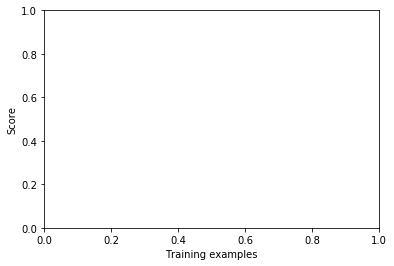

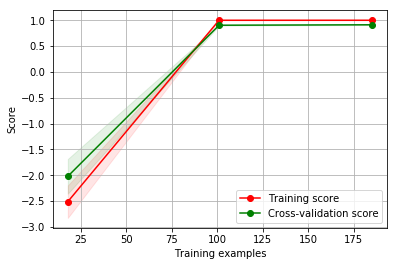

In [31]:
#grid.cv_results_
#grid.best_params_
#pipe.named_steps['vct'].variances_
#len(pipe.named_steps['vct'].get_support(True))

train_sizes=np.linspace(.1, 1.0, 3)

import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
plt.figure()
#plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    pipe, X, y, cv=3, n_jobs=-1, train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [4]:
# Search bin subdivision so that there is highest variance
# 1. Divide hist into bins over some rows
# 2. Compute std -> divide bins where it's high, join/drop those where it's low
# 3. Repeat / change rows
kmeans = KMeans(n_clusters=8, n_jobs=-1, random_state=42)

samples = X[0: 5]
centers = []
for i, sample in enumerate(samples):
    # sample = sample[1672390 : -786303]

    sample = sample[(sample > 0) & (sample < 1800)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))

    #samples[i] = sample
    #print(str(i) + ' done')

if True: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))

print('n edges: ' + str(len(edges)))
edges

n edges: 40


[array([  316.06548606,   516.04062473,   672.03912953,   788.4017923 ,
          912.68082233,  1063.06793716,  1221.11834124,  1370.37759073]),
 array([  308.77309614,   504.8323311 ,   661.04570736,   783.16988715,
          921.22162422,  1080.41577968,  1247.41710179,  1393.10546197]),
 array([  259.42693236,   454.41115039,   637.10735577,   783.24697727,
          918.05688785,  1076.03364154,  1238.7439229 ,  1383.01276065]),
 array([  284.2603614 ,   461.84852282,   647.97452156,   826.76038816,
          980.3224361 ,  1135.55237028,  1308.37312973,  1473.53302531]),
 array([  277.75613471,   482.81300987,   649.12127803,   776.62490065,
          913.78209436,  1076.42318956,  1235.8621241 ,  1375.33653253])]

In [ ]:
from sklearn.utils import resample

edges = [1,
 175, 190.0, 200, 210, 220, 230.0, 240, 250.29576676838963, 260.59153353677925, 270.7998907955566, 281.00824805433393, 296.51672876785585, 312.4192910985714, 328.7096455492857,
 345, 365.11915911105507, 385.23831822211014, 421.68407741265736, 458.1298366032046, 517.3519134270805, 576.5739902509565, 609.5574644576008, 626.0492015609229, 642.540938664245, 655.0834926946815, 666.5424184427528, 680, 688.7915018861073, 697.5830037722146, 705.1660075444291, 712.7490113166436, 720.3320150888583, 730.1660075444291, 740, 747.7243484748634, 755.4486969497268, 763.1730454245902, 770.8973938994536,
 778.3608893423097, 785.8243847851659, 792.7855130483395, 799.7466413115131, 807.5810902304434, 816.5985296073651, 825.6159689842868, 836.8877682054391, 848.1595674265914, 863.9400863362044, 879.7206052458175, 905.8611747488183, 932.0017442518191, 950.2522817644435, 968.5028192770679,
 995.0990029527295, 1021.6951866283912, 1045.622987987501, 1084.7830302704533, 1123.9430725534057, 1178.3353557602009, 1203.4127942147347, 1228.4902326692686, 1240.8414534419671, 1253.1926742146657, 1265.5438949873642, 1277.8951157600625, 1288.9475578800311, 1300, 1309.8438400564696, 1319.6876801129395,
 1329.5315201694093, 1339.375360225879, 1347.7457855765365, 1356.1162109271943, 1365.7868972366239, 1375.4575835460535, 1386.4285308142548, 1400, 1408.3298109092373, 1416.6596218184745, 1424.9894327277118, 1433.319243636949, 1442, 1448.5, 1461.25, 1470.625, 1480, 1490.0, 1500,1509.375,
 1518.75, 1530, 1546.25, 1562.5, 1581.25, 1610, 1700.0]
hists = []
for x in X:#resample(X, n_samples=100):
    hists.append(np.histogram(x, bins=edges)[0])
    
std_all = np.std(np.array(hists).flatten())
for bin_i in range(len(hists[0])):
    arr = [h[bin_i] for h in hists]
    print("bin "+str(bin_i)+": "+str(np.std(arr) / std_all))

In [ ]:
from IPython.display import display
new_edges = edges # attention: 49 bins = 50 edges
for i in range(1):
    # compute hists for samples
    hists = []
    for x in X:
        hists.append(np.histogram(x, bins=new_edges)[0])

    ed = [1]
    for bin_i in range(len(hists[0])):
        # compute std for bin i
        arr = [h[bin_i] for h in hists]
        std = np.std(arr) / std_all
        
        if std > 0.35: # if std over threshold, split bin
            ed.append(0.5 * (new_edges[bin_i] + new_edges[bin_i+1])) 
            
        if std < 0.2: # if std too low, join with next bin
            continue
            
        ed.append(new_edges[bin_i+1])
        
    new_edges = ed
    if len(new_edges)>=120: break
        
print(len(new_edges))
display(new_edges)

In [55]:
import random
def run(a, b):  
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=a, hist_bins=b,
            bin_length=50, images_x_from=50, images_x_to=125, images_y_to=196)),
        ('scaler', StandardScaler()),
        ('vct', VarianceThreshold(threshold=1.0)),
        #('linreg', LinearRegression(n_jobs=-1))
        ('linearSVR', LinearSVR(C=1.0, max_iter=1300))
    ])

    pipe.fit(X[0:150], y[0:150])
    y_pr = pipe.predict(X[151:228])
    print("\x1b[1;31m%s\x1b[0m \t%s\t%s" % (mean_squared_error(y[151:228], y_pr), a, b))
    #print("\t", hist_bins)

In [ ]:
some_bins = [  1.00000000e+00,   2.43148939e+02 ,  5.52670768e+02,   6.63323565e+02,   7.82650357e+02 ,  1.02133853e+03 ,  1.08620935e+03,   1.20392913e+03,   1.39695300e+03 ,  1.75176484e+03]
bins = [[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]

def random_bins():
    new_bins = [1]
    for j in range(1, len(some_bins)):
        b = some_bins[j]
        new_bins.append(random.uniform(b - 80, b + 80))
    return list(np.sort(new_bins))

#run(610, bins) # this run is to get a reference score
for i in range(0, 100):
    bins = []
    bins.append(random_bins())
    bins.append(random_bins())
    bins.append(random_bins())
    bins.append(random_bins())
    bins.append(random_bins())
    bins.append(random_bins())    
    
    run(610, bins)   


46.2502180111 	610	[[1.0, 235.24866102437392, 555.10806045767185, 620.5717939683982, 757.70009508231635, 1048.0503974252849, 1069.6282568493964, 1172.8380040177735, 1426.2991819200652, 1704.724857281253], [1.0, 196.97293715079408, 508.88611185918899, 632.28590798140442, 737.64760569656619, 1000.6238686589269, 1063.0320025934247, 1246.2418278217524, 1372.4446332737627, 1759.490255773924], [1.0, 222.6821748749509, 575.23988224140624, 624.73118483342137, 767.10725854227485, 985.5677797281686, 1066.7153190258327, 1179.9669408904613, 1392.192386749085, 1796.1197198250736], [1.0, 195.87071682278457, 525.83075036919661, 674.15022798621885, 816.13269538465306, 1009.297461936368, 1072.0930455885311, 1185.7267021432633, 1384.4796322828511, 1755.5963250281472], [1.0, 271.12866763470106, 504.82441496759645, 630.9178020384021, 754.86227251056528, 1033.4115925509616, 1112.2632122300427, 1160.9749895790046, 1347.0272744163092, 1713.161222493889]]

46.8002965385 	610	[[1.0, 218.55506230929186, 586.75418437206781, 652.2394559820674, 773.8961704594326, 1070.3001532069275, 1132.0119600739936, 1184.2612806674767, 1346.9641002898002, 1718.9557380387023], [1.0, 290.69893927293026, 572.90674625326255, 636.50257766581979, 823.0771012780242, 1059.0456553618278, 1107.4247015526541, 1155.7078943964748, 1399.8097447227119, 1724.0035902340619], [1.0, 218.72954212410218, 542.01253539936533, 653.43333213996402, 821.07268841149516, 1008.7924651333656, 1052.8010062125443, 1169.5052456580929, 1393.3189036641181, 1729.5274681498695], [1.0, 277.08527226987928, 565.65467450638698, 686.47530217708209, 750.38473433034494, 1028.017525595182, 1105.2834708322937, 1158.7544772919573, 1386.8471781779679, 1768.5751652257886], [1.0, 208.48377822151147, 598.37983146074566, 634.52319035808785, 744.42188750405739, 1040.1030410463857, 1134.7469964800446, 1231.2439735529522, 1400.1500086069593, 1734.6145682992137]]

49.0396154526 	610	[[1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484], [1.0, 169.07888603029684, 476.3993832496185, 659.11986598803605, 833.79724742451754, 954.32415399945558, 1074.2765867000755, 1137.6921525931543, 1366.5221080300698, 1672.6717108194036], [1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484]]

48.7184635539 	610	[[1.0, 243.148939, 552.670768, 663.323565, 782.650357, 1021.33853, 1086.20935, 1203.92913, 1396.953, 1751.76484], [1.0, 209.35283091979062, 536.59779906296069, 665.28712643428412, 846.84903546339149, 977.79123010728188, 1090.068463939142, 1282.5916662093121, 1350.8990626146378, 1775.4138020921694], [1.0, 189.36260739832539, 563.41978511220316, 652.87738609203211, 793.14021532167249, 945.93292735133036, 1038.5351281645719, 1268.0203915696984, 1345.7126149793392, 1719.8402573532387], [1.0, 321.42123027902852, 513.40658875027952, 676.08423490399321, 771.55097096222892, 941.85367259894826, 1109.1807381440169, 1204.4056231152172, 1466.8640638996865, 1828.0303138977495], [1.0, 174.99250489989211, 566.78723432351444, 637.93448070218324, 723.7844766038387, 1020.7683940864266, 1088.0469595895363, 1204.2431024253162, 1354.1723380995209, 1763.4259373890307]]

47.6369255523 	610	[[1.0, 150.56137278787102, 457.33153706202313, 658.06894123504503, 846.58397003064692, 937.57055999931936, 1071.2933958750946, 1121.1329082414429, 1358.9143850375874, 1652.8984285242545], [1.0, 209.08847589309377, 557.35118459195758, 603.4824475881037, 840.09353019069886, 932.41851138730772, 1028.4963859465074, 1155.4444447957785, 1377.7665328071323, 1804.5238259461053], [1.0, 213.9106433574936, 591.67054972204392, 708.8357454735019, 747.76344324889669, 1094.1244196827156, 1106.1429563548058, 1253.3733914174486, 1418.5599131213776, 1733.4247323867448], [1.0, 162.44558827529511, 481.40325003988937, 598.15057979065659, 718.17945850568867, 950.44081956361697, 1027.7252142536861, 1216.1222768235052, 1451.0664305285418, 1811.3579605658706], [1.0, 312.37402267538255, 476.11342209986088, 719.84074466372897, 727.79325764999419, 935.81641849656705, 1043.7522060542294, 1221.0676377127122, 1306.4885292222425, 1695.0292713230729]]